### Importing packages

#### Others

In [1]:
# Used to read the data file
import pandas as pd

# Used in the definition of the model and its initial condition
import numpy as np

# Used for plots other than those generated by the parameter estimation module
import matplotlib.pyplot as plt
%matplotlib inline

#### The module itself

In [2]:
import PDEparams as pde

### Defining the model

We use the two-dimensional model of tumour growth from Eq. (5) of [Anderson *et al.* (2000)](http://dx.doi.org/10.1080/10273660008833042):

$$\begin{align}
\frac{\partial n}{\partial t} &= d_n \nabla^2 n - \gamma \nabla \cdot (n \nabla f)\\
\frac{\partial f}{\partial t} &= - \eta m f\\
\frac{\partial m}{\partial t} &= d_m \nabla^2 m + \alpha n - \beta m
\end{align}$$

This model describes the invasion and degradation of surrounding host tissue by tumour cells. The latter are represented in the model by $n$, while $f$ is the surrounding tissue or *extracellular matrix* (ECM); $m$, in turn, corresponds to *matrix degradative enzymes* (MDEs), which are activated by the tumour cells and degrade the ECM, as their name implies.

**Note:** in the original simulations, the parameter $\beta$ is set to zero. We do the same here.

#### Boundary conditions

We use no-flux boundary conditions in the 2D domain defined by the data. Eqs. (6)-(7) of Anderson *et al.* (2000) translate to

$$\frac{\partial n}{\partial x} = \frac{\gamma n}{d_n}\frac{\partial f}{\partial x}$$

at the $x$ boundaries; and equivalently for $y$.

Note that the equation for $f$ does not have spatial derivatives, and therefore no boundary conditions. In the code below, the derivatives of $f$ entering the equation for $n$ are computed directly, and then plugged into the condition for the first-order derivative of $n$.

#### Second-order derivatives of $n$ and $m$

In practice, if we consider the variable $u$ ($n$ or $m$) as a discrete 1D vector $(u_0, u_1, ...)$, then we can obtain the central differences

$$\begin{align}
h\, u'_i &= u_{i+1}-u_{i-1}\\
h^2\, u''_i &= u_{i+1}+u_{i-1}-2u_i
\end{align}$$

where $h=dx$, $u' = \partial u/\partial x$, and $u'' = \partial^2 u/\partial x^2$. If we have a boundary condition $u'_0 = \sigma$, and we take an imaginary point $u_{-1}$ to the left of our domain so that

$$h^2\, u''_0 = u_{1}+u_{-1}-2u_0$$

at the boundary, we obtain from the first-order difference $u_{-1} = u_1 - h \sigma$. Therefore, in our case

$$\begin{align}h^2n''_0 &= 2n_1 - h \gamma n_0 f'_0/d_n - 2n_0\\
h^2m''_0 &= 2m_1 - 2m_0
\end{align}$$

The same idea applies in the 2D case to the four boundaries.

In [3]:
def TumourGrowth(z, t, grid, alpha, gamma):
    
    '''The input z corresponds to the current state of the system, and it's a flattened vector in both the number
    of outputs and the spatial dimensions. 
    
    t is the current time.
    
    grid is the spatial grid of the model.

    alpha and gamma correspond to the unknown parameters.
    '''
    
    # Known parameter values (same as in the paper)
    
    dN = 1e-3
    dM = 1e-3
    eta = 10.
    
    '''Here we obtain both functions by reshaping the input: we divide it into 3 portions (number of outputs)
    of whatever shape the spatial grid has (this is what the -1 stands for)'''
    
    N, F, M = z.reshape(3,-1)
    
    '''Now we reshape both functions using the actual dimensions of the spatial grid.
    
    The shape of the spatial grid array is given by:
    
                        (number of points in dim 1, number of points in dim 2, ..., ndims)
                        
    with ndims the number of spatial dimensions. This is due to the fact that we have a grid of 
                        
                        (number of points in dim 1)x(number of points in dim 2)
                        
    elements, but each element is ndims-dimensional. Therefore, we must take the first "ndims" elements of the
    shape of the grid, ignoring the last one, to reconstruct the shape of each function. The slice with [:-1]
    stands for "all elements up to and excluding the last one".
    '''
    
    N = N.reshape(grid.shape[:-1])
    
    F = F.reshape(grid.shape[:-1])
    
    M = M.reshape(grid.shape[:-1])
    
    '''The grid has the form
                
                (x0,y0), (x0,y1), ...
                (x1,y0), (x1,y1), ...
                
    So that:
        x0 = first element of the first element of the first row of the grid: grid[0,0,0]
        x1 = first element of the first element of the second row of the grid: grid[1,0,0]
        y0 = second element of the first element of the first row of the grid: grid[0,0,1]
        y1 = second element of the second element of the first row of the grid: grid[0,1,1]
    '''
    
    dx = grid[1,0,0]-grid[0,0,0]
    dy = grid[0,1,1]-grid[0,0,1]
    
    # We initialise the spatial derivatives we need as empty arrays of the same shape of our N and L functions
    
    dNdx = np.empty_like(N)
    dNdy = np.empty_like(N)
    dNdxx = np.empty_like(N)
    dNdyy = np.empty_like(N)
    
    dMdxx = np.empty_like(M)
    dMdyy = np.empty_like(M)
    
    #First-order derivatives
    
    # np.gradient(array, axis) returns centred 1st-order differences between values along x (rows, axis=0)
    # or y (columns, axis=1), plus forward/backward differences for the left/right boundaries
    dFdx = np.gradient(F, axis=0)/dx
    dFdy = np.gradient(F, axis=1)/dy
    
     
    # Left boundary. In the grid array, first row, all columns: [0,:]
    dNdx[0,:] = gamma*N[0,:]*dFdx[0,:]/dN
    
    # Away from the x-boundary. In the grid array, second to penultimate row, all columns: [1:-1,:]
    dNdx[1:-1,:] = np.gradient(N, axis=0)[1:-1,:]/dx
    
    # Right boundary. In the grid array, last row, all columns: [-1,:]
    dNdx[-1,:] = gamma*N[-1,:]*dFdx[-1,:]/dN
    
    # Bottom boundary. In the grid array, all rows, first column: [:,0]
    dNdy[:,0] = gamma*N[:,0]*dFdy[:,0]/dN
    
    # Away from the y-boundary. In the grid array, all rows, second to penultimate columns: [:,1:-1]
    dNdy[:,1:-1] = np.gradient(N, axis=1)[:,1:-1]/dy
    
    # Right boundary. In the grid array, all rows, last column: [:,-1]
    dNdy[:,-1] = gamma*N[:,-1]*dFdy[:,-1]/dN
    
    # Second-order derivatives
    
    dFdxx = np.gradient(dFdx, axis=0)/dx
    dFdyy = np.gradient(dFdy, axis=1)/dy
    
    # Left boundary. In the grid array, first row, all columns: [0,:]
    dNdxx[0,:] = (2.0*N[1,:] - dx*gamma*N[0,:]*dFdx[0,:]/dN - 2.0*N[0,:])/dx**2
    
    # Away from the x-boundary. In the grid array, second to penultimate row, all columns: [1:-1,:]
    # np.diff(array, order, axis) is used to compute 2nd-order differences between values along x, or rows (axis=0)
    dNdxx[1:-1,:] = np.diff(N,2,axis=0)/dx**2
    
    # Right boundary. In the grid array, last row, all columns: [-1,:]
    dNdxx[-1,:] = (2.0*N[-2,:] - dx*gamma*N[-1,:]*dFdx[-1,:]/dN - 2.0*N[-1,:])/dx**2
    
    # Bottom boundary. In the grid array, all rows, first column: [:,0]
    dNdyy[:,0] = (2.0*N[:,1] - dy*gamma*N[:,0]*dFdy[:,0]/dN - 2.0*N[:,0])/dy**2
    
    # Away from the y-boundary. In the grid array, all rows, second to penultimate columns: [:,1:-1]
    # np.diff(array, order, axis) is used to compute 2nd-order differences between values along y, or columns (axis=1)
    dNdyy[:,1:-1] = np.diff(N,2,axis=1)/dy**2
    
    # Right boundary. In the grid array, all rows, last column: [:,-1]
    dNdyy[:,-1] = (2.0*N[:,-2] - dy*gamma*N[:,-1]*dFdy[:,-1]/dN - 2.0*N[:,-1])/dy**2
    
    # Now the same for M
        
    dMdxx[0,:] = (2.0*M[1,:] - 2.0*M[0,:])/dx**2
    dMdxx[1:-1,:] = np.diff(M,2,axis=0)/dx**2
    dMdxx[-1,:] = (2.0*M[-2,:] - 2.0*M[-1,:])/dx**2
    
    dMdyy[:,0] = (2.0*M[:,1] - 2.0*M[:,0])/dy**2
    dMdyy[:,1:-1] = np.diff(M,2,axis=1)/dy**2
    dMdyy[:,-1] = (2.0*M[:,-2] - 2.0*M[:,-1])/dy**2
    
    
    # Adding the rest of the terms to obtain the time derivatives
    
    dNdt = dN*(dNdxx + dNdyy) - gamma*(dNdx*dFdx + dNdy*dFdy + N*(dFdxx + dFdyy))
    dFdt = -eta*M*F
    dMdt = dM*(dMdxx + dMdyy) + alpha*N
    
    # We put the three time derivatives side by side
    
    dzdt = np.array([dNdt, dFdt, dMdt])
    
    return dzdt.reshape(-1) # We return a completely flattened version of the total time derivative

Here we specify the functions that define the initial condition for each variable&mdash;Eq. (9) of Anderson *et al.* (2000).

For this example, we used an arbitrarily chosen heterogeneous cellular matrix to generate the data, as in Fig. 8 of the paper.

In [4]:
def initial_N(z, centre=[0.5,0.5], rad=0.1):
    epsilon = 2.5e-3
    x, y = z
    
    r = np.sqrt((x - centre[0])**2 + (y - centre[1])**2)
    
    if r <= rad:
        return np.exp(-r**2/epsilon)
    
    return 0.

# Homogeneous ECM (only for reference)
def initial_F(z):
    return 1. - 0.5*initial_N(z)

# Heterogeneous ECM
def initial_F2(z):
    return (1. - initial_N(z, rad=0.5) - 0.5*initial_N(z, centre=[0.8,0.8], rad=0.2)
            - 0.8*initial_N(z, centre=[0.2,0.2], rad=0.1) - 0.6*initial_N(z, centre=[0.05,0.6], rad=0.3)
            - 0.3*initial_N(z, centre=[0.6,0.1], rad=0.05) - initial_N(z, centre=[0.6,0.6], rad=0.5)
            - initial_N(z, centre=[0.8,0.4], rad=0.5) - initial_N(z, centre=[0.9,0.2], rad=0.5)
            - initial_N(z, centre=[0.3,0.8], rad=0.7))

def initial_M(z):
    return 0.5*initial_N(z)

### Using `PDEparams` to estimate parameters

First, we load the data from the `.csv` file.

The data consist of 3 replicates, and have been generated using parameter values $\alpha=0.1$, $\gamma=0.005$, as in the paper.

The columns are, in order: $t$, $x$, $y$, $n$, $f$, $m$.

In [5]:
df = pd.read_csv('TumourGrowthData.csv')

df.head()

,0,1,2,3,4,5
0,1.0,0.0,0.020408,0.001154,1.001187,0.000670
1,1.0,0.0,0.020408,0.000828,0.998376,0.000000
2,1.0,0.0,0.020408,0.000000,0.998738,0.001314
3,1.0,0.0,0.061224,0.001059,1.000115,0.000000
4,1.0,0.0,0.061224,0.000886,0.999843,0.000075


#### Constructing the `PDEmodel` object.

The inputs are

**Required:**
1. The data table `df`.
2. The model `TumourGrowth`.
3. The list of initial condition functions.
4. The bounds for the parameter values.

**Optional:**
1. The parameter names.
2. The number of variables: 3. **(Default is 1, this needs to be provided in this case)**
3. The number of spatial dimensions: 2. **(Default is 1, this needs to be provided in this case)**
4. The number of replicates in the data: 3. **(Default is 1, this needs to be provided in this case)**
5. The indices of the measured variables. In this case, the default `None`, since we have data for all 3 variables.
6. The function to apply to the output. In this case, the default `None`, since our data is directly $n$, $f$ and $m$.

In [6]:
my_model = pde.PDEmodel(df, TumourGrowth, [initial_N, initial_F2, initial_M], 
                        bounds=[(0.05, 0.15), (0.002,0.01)], param_names=[r'$\alpha$', r'$\gamma$'], 
                        nvars=3, ndims=2, nreplicates=3, obsidx=None, outfunc=None)

Let us plot the initial condition.

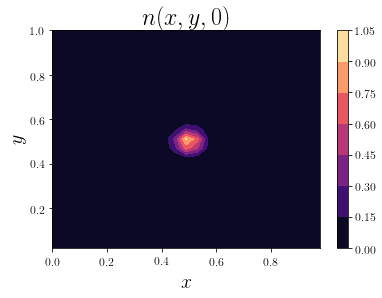

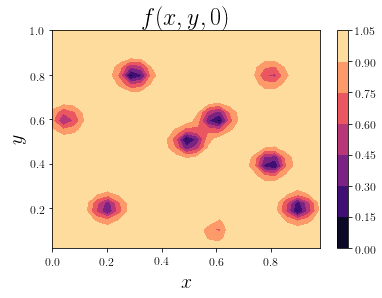

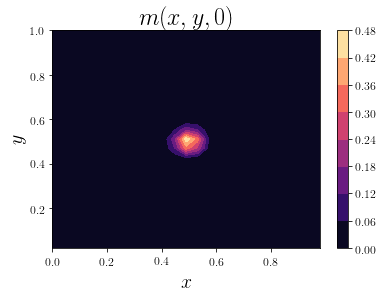

In [7]:
X = my_model.space[:,:,0] # all x values
Y = my_model.space[:,:,1] # all y values

plt.contourf(X,Y,my_model.initial_condition[0], cmap='magma')
plt.colorbar()
plt.title(r'$n(x,y,0)$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

plt.contourf(X,Y,my_model.initial_condition[1], cmap='magma')
plt.colorbar()
plt.title(r'$f(x,y,0)$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

plt.contourf(X,Y,my_model.initial_condition[2], cmap='magma')
plt.colorbar()
plt.title(r'$m(x,y,0)$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

#### Finding the best fit parameters.

In [8]:
%%time
my_model.fit()

   $\alpha$  $\gamma$
0  0.103305  0.005293
CPU times: user 1min 42s, sys: 1.98 s, total: 1min 44s
Wall time: 1min 39s


In [9]:
my_model.best_params

,$\alpha$,$\gamma$
0,0.103305,0.005293


In [10]:
my_model.best_error

1.3730150561063116e-05

#### Likelihood profiles

We use a grid of 25 points per parameter.

**Note:** if you see a "widget not found" message, just ignore it; a progress bar will appear when you run the cell below.

In [13]:
%%time
my_model.likelihood_profiles(npoints=25)

CPU times: user 1h 21min 4s, sys: 8min 19s, total: 1h 29min 23s
Wall time: 1h 2min 39s


The raw results

In [14]:
my_model.result_profiles

,parameter,value,error
0,$\alpha$,0.050000,0.001016
1,$\alpha$,0.054167,0.000785
2,$\alpha$,0.058333,0.000602
3,$\alpha$,0.062500,0.000460
4,$\alpha$,0.066667,0.000345
5,$\alpha$,0.070833,0.000254
6,$\alpha$,0.075000,0.000182
7,$\alpha$,0.079167,0.000127
8,$\alpha$,0.083333,0.000086
9,$\alpha$,0.087500,0.000056


Visualisation

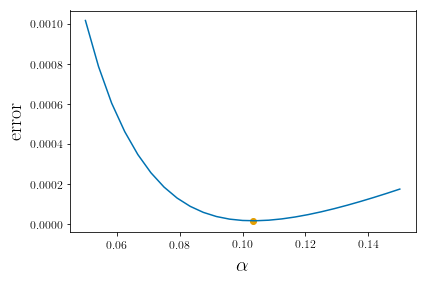

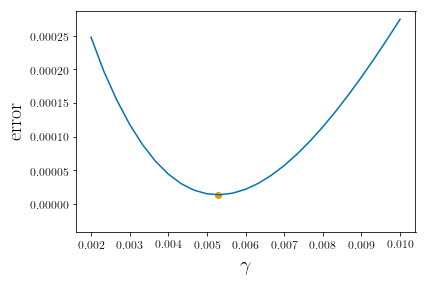

In [15]:
my_model.plot_profiles()

#### Bootstrapping

We use 50 repetitions.

**Note:** if you see a "widget not found" message, just ignore it; a progress bar will appear when you run the cell below.

In [16]:
%%time
my_model.bootstrap(nruns=50)

        $\alpha$   $\gamma$
count  50.000000  50.000000
mean    0.103383   0.005287
std     0.000092   0.000007
min     0.103137   0.005275
25%     0.103337   0.005283
50%     0.103400   0.005286
75%     0.103443   0.005291
max     0.103549   0.005304
CPU times: user 1h 13min 4s, sys: 2min 24s, total: 1h 15min 28s
Wall time: 1h 8min 14s


The summary

In [17]:
my_model.bootstrap_summary

,$\alpha$,$\gamma$
count,50.000000,50.000000
mean,0.103383,0.005287
std,0.000092,0.000007
min,0.103137,0.005275
25%,0.103337,0.005283
50%,0.103400,0.005286
75%,0.103443,0.005291
max,0.103549,0.005304


The raw results

In [18]:
my_model.bootstrap_raw

,$\alpha$,$\gamma$
0,0.103280,0.005294
1,0.103292,0.005293
2,0.103409,0.005285
3,0.103407,0.005284
4,0.103543,0.005276
5,0.103406,0.005286
6,0.103409,0.005286
7,0.103237,0.005297
8,0.103427,0.005283
9,0.103400,0.005286


Visualisation

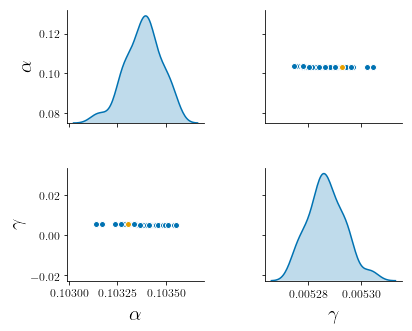

In [19]:
my_model.plot_bootstrap()

### Only one observed variable

Let us suppose now that we only have data for $m$.

In [20]:
df2 = df[df.columns[[0,1,2,5]]] # n and f, which we are ignoring, are columns 3 and 4 in the data table

df2.head()

,0,1,2,5
0,1.0,0.0,0.020408,0.000670
1,1.0,0.0,0.020408,0.000000
2,1.0,0.0,0.020408,0.001314
3,1.0,0.0,0.061224,0.000000
4,1.0,0.0,0.061224,0.000075


#### Constructing the `PDEmodel` object.

The inputs are the same as before, except for the data&mdash;now `df2` instead of `df`&mdash;and `obsidx`, which specifies that we only have data for the 3rd variable in the system. Starting from zero, the corresponding index is 2. Since we only have one observed variable, `obsidx` can be either a number or a list of one element.

In [21]:
my_model2 = pde.PDEmodel(df2, TumourGrowth, [initial_N, initial_F2, initial_M], 
                        bounds=[(0.05, 0.15), (0.002,0.01)], param_names=[r'$\alpha$', r'$\gamma$'], 
                        nvars=3, ndims=2, nreplicates=3, obsidx=[2], outfunc=None)

#### Finding the best fit parameters.

In [22]:
%%time
my_model2.fit()

   $\alpha$  $\gamma$
0  0.098852  0.005657
CPU times: user 1min 14s, sys: 2.89 s, total: 1min 17s
Wall time: 1min 8s


In [23]:
my_model2.best_params

,$\alpha$,$\gamma$
0,0.098852,0.005657


In [24]:
my_model2.best_error

1.0316723898609223e-06

#### Likelihood profiles

**Note:** if you see a "widget not found" message, just ignore it; a progress bar will appear when you run the cell below.

In [25]:
%%time
my_model2.likelihood_profiles(npoints=25)

CPU times: user 49min 40s, sys: 3min 25s, total: 53min 5s
Wall time: 42min 29s


The raw results

In [26]:
my_model2.result_profiles

,parameter,value,error
0,$\alpha$,0.050000,0.000020
1,$\alpha$,0.054167,0.000017
2,$\alpha$,0.058333,0.000014
3,$\alpha$,0.062500,0.000011
4,$\alpha$,0.066667,0.000009
5,$\alpha$,0.070833,0.000007
6,$\alpha$,0.075000,0.000005
7,$\alpha$,0.079167,0.000004
8,$\alpha$,0.083333,0.000003
9,$\alpha$,0.087500,0.000002


Visualisation

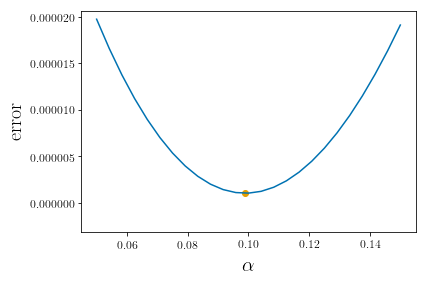

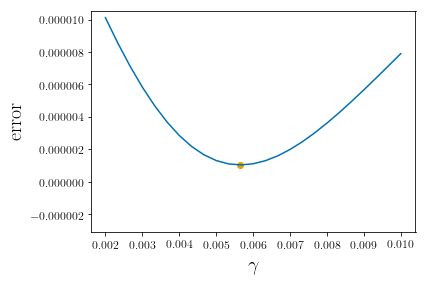

In [27]:
my_model2.plot_profiles()

#### Bootstrapping

**Note:** if you see a "widget not found" message, just ignore it; a progress bar will appear when you run the cell below.

In [28]:
%%time
my_model2.bootstrap(nruns=50)

        $\alpha$   $\gamma$
count  50.000000  50.000000
mean    0.098954   0.005656
std     0.000135   0.000013
min     0.098674   0.005623
25%     0.098862   0.005648
50%     0.098947   0.005656
75%     0.099022   0.005664
max     0.099387   0.005684
CPU times: user 58min 36s, sys: 1min 58s, total: 1h 34s
Wall time: 54min 28s


The summary

In [29]:
my_model2.bootstrap_summary

,$\alpha$,$\gamma$
count,50.000000,50.000000
mean,0.098954,0.005656
std,0.000135,0.000013
min,0.098674,0.005623
25%,0.098862,0.005648
50%,0.098947,0.005656
75%,0.099022,0.005664
max,0.099387,0.005684


The raw results

In [30]:
my_model2.bootstrap_raw

,$\alpha$,$\gamma$
0,0.099155,0.005673
1,0.098928,0.005642
2,0.098944,0.005658
3,0.098741,0.005661
4,0.098947,0.005634
5,0.098973,0.005646
6,0.099091,0.005654
7,0.099073,0.005669
8,0.099001,0.005655
9,0.098858,0.005656


Visualisation

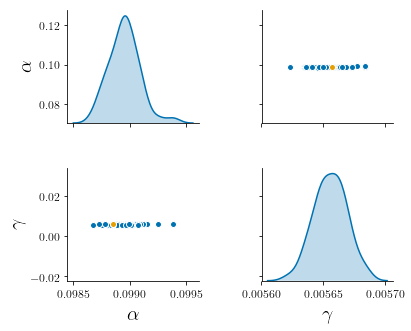

In [31]:
my_model2.plot_bootstrap()

### Only a function of the variables is observed

Finally, we consider the case when it's not the raw outputs of the system that are observed, but rather a function of them. In this case, let us assume that the observed quantity is

$$\mathcal{F}(n, f, m) = n^2 - m$$

In [32]:
df3 = df[df.columns[[0,1,2]]] # we take only the space-time coordinates

# We add the new function
df3[r'$\mathcal{F}$'] = df['3']*df['3'] - df['5'] # n and m are, respectively, columns 3 and 5 in the data table

df3.head()

,0,1,2,$\mathcal{F}$
0,1.0,0.0,0.020408,-6.687299e-04
1,1.0,0.0,0.020408,6.859981e-07
2,1.0,0.0,0.020408,-1.314136e-03
3,1.0,0.0,0.061224,1.122511e-06
4,1.0,0.0,0.061224,-7.427586e-05


#### Constructing the `PDEmodel` object.

The inputs are the same as before, except for the data&mdash;now `df3`&mdash;and `outfunc`, which specifies the function to be applied to the outputs before computing the error. Note that, even if the output function uses only 2 of the variables, we need to pass the full output vector as an argument (see below). In this case, `obsidx` is ignored, but we set it to `None` anyway.

In [33]:
def F(z):
    n, f, m = z
    
    return n**2-m

In [34]:
my_model3 = pde.PDEmodel(df3, TumourGrowth, [initial_N, initial_F2, initial_M], 
                        bounds=[(0.05, 0.15), (0.002,0.01)], param_names=[r'$\alpha$', r'$\gamma$'], 
                        nvars=3, ndims=2, nreplicates=3, obsidx=None, outfunc=F)

#### Finding the best fit parameters.

In [37]:
%%time
my_model3.fit()

   $\alpha$  $\gamma$
0  0.099206  0.005681
CPU times: user 1min 46s, sys: 1.7 s, total: 1min 47s
Wall time: 1min 44s


In [38]:
my_model3.best_params

,$\alpha$,$\gamma$
0,0.099206,0.005681


In [39]:
my_model3.best_error

1.106811988396949e-06

#### Likelihood profiles

**Note:** if you see a "widget not found" message, just ignore it; a progress bar will appear when you run the cell below.

In [40]:
%%time
my_model3.likelihood_profiles(npoints=25)

CPU times: user 1h 5min, sys: 3min 13s, total: 1h 8min 13s
Wall time: 58min 3s


The raw results

In [41]:
my_model3.result_profiles

,parameter,value,error
0,$\alpha$,0.050000,0.000021
1,$\alpha$,0.054167,0.000018
2,$\alpha$,0.058333,0.000015
3,$\alpha$,0.062500,0.000012
4,$\alpha$,0.066667,0.000010
5,$\alpha$,0.070833,0.000008
6,$\alpha$,0.075000,0.000006
7,$\alpha$,0.079167,0.000004
8,$\alpha$,0.083333,0.000003
9,$\alpha$,0.087500,0.000002


Visualisation

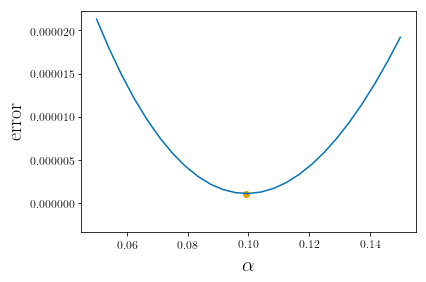

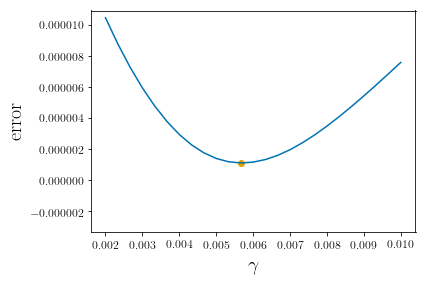

In [42]:
my_model3.plot_profiles()

#### Bootstrapping

**Note:** if you see a "widget not found" message, just ignore it; a progress bar will appear when you run the cell below.

In [43]:
%%time
my_model3.bootstrap(nruns=50)

        $\alpha$   $\gamma$
count  50.000000  50.000000
mean    0.099367   0.005695
std     0.000141   0.000015
min     0.099032   0.005660
25%     0.099296   0.005686
50%     0.099364   0.005694
75%     0.099442   0.005702
max     0.099672   0.005729
CPU times: user 1h 6min 39s, sys: 2min 1s, total: 1h 8min 40s
Wall time: 1h 2min 20s


The summary

In [44]:
my_model3.bootstrap_summary

,$\alpha$,$\gamma$
count,50.000000,50.000000
mean,0.099367,0.005695
std,0.000141,0.000015
min,0.099032,0.005660
25%,0.099296,0.005686
50%,0.099364,0.005694
75%,0.099442,0.005702
max,0.099672,0.005729


The raw results

In [45]:
my_model3.bootstrap_raw

,$\alpha$,$\gamma$
0,0.099379,0.005704
1,0.099286,0.005696
2,0.099366,0.005700
3,0.099502,0.005692
4,0.099267,0.005714
5,0.099397,0.005678
6,0.099320,0.005691
7,0.099672,0.005721
8,0.099243,0.005691
9,0.099160,0.005689


Visualisation

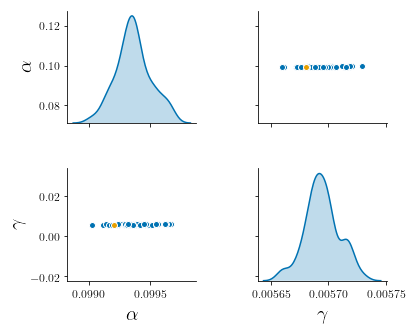

In [46]:
my_model3.plot_bootstrap()